In [1]:
import numpy as np
from scipy import stats
from multiprocessing import Pool
from randomgen import Generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from epsie.proposals import Normal, BoundedDiscrete, NestedTransdimensional
from epsie.samplers import MetropolisHastingsSampler


import sys
sys.path.append('dev_tests/')
from regression_model import PolynomialRegressionModel

## The suggested object handling births

In [2]:
class UniformBirthDistribution(object):
    _random_generator = Generator()
    
    def __init__(self, parameters, bounds):
        self.parameters = parameters
        self.bounds = bounds
        
    def set_bit_generator(self, bit_generator):
        self._random_generator = Generator(bit_generator)
    
    @property
    def birth(self):
        if self._random_generator is None:
            raise ValueError('must set the random generator first')
        return {p: self._random_generator.uniform(self.bounds[p][0], self.bounds[p][1]) for p in self.parameters}
    
    def logpdf(self, xi):
        return sum([stats.uniform.logpdf(xi[p], loc=self.bounds[p][0],
                                         scale=self.bounds[p][1] - self.bounds[p][0]) for p in self.parameters])

## Create the model

(-0.0, -5.950642552587727)


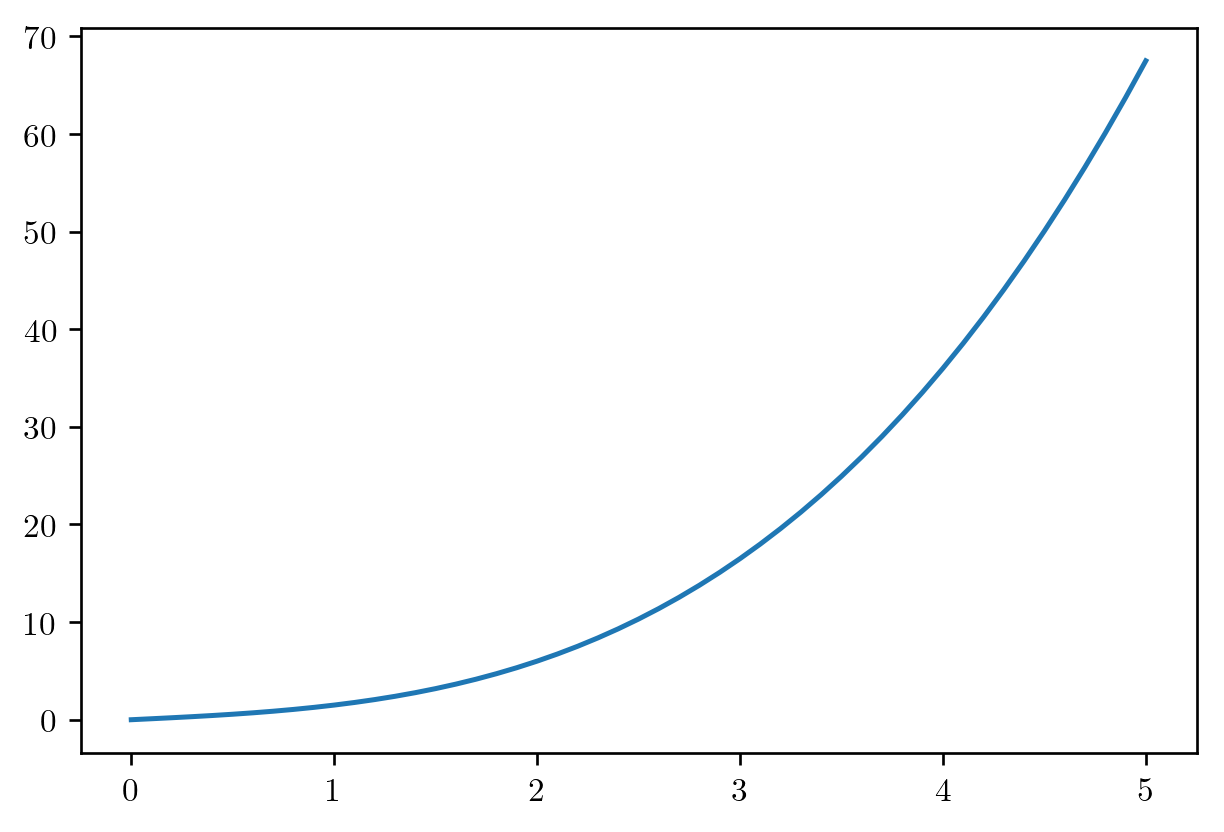

In [3]:
model = PolynomialRegressionModel(seed=4)

print(model(**model.true_signal))
nchains = 12
ntemps = None

newp = model.prior_rvs(nchains, ntemps)

plt.figure(dpi=120)
plt.plot(model.t, model.ysignal)
plt.show()

In [4]:
# Initialise the birth-objects for transdimensional parameters
birth_dists = [UniformBirthDistribution(['a{}'.format(i)], {'a{}'.format(i): (-2., 2.)}) for i in range(1, 5+1)]
# Initialies transdimensional proposals
td_proposals = [Normal(['a{}'.format(i)], cov=0.4) for i in range(1, 5+1)]
# Initialise the global proposal that is always on
global_proposals = [Normal(['a0'], cov=0.4)]
# Model hopping proposal. Note that is possible
model_proposal = BoundedDiscrete(['k'], boundaries={'k': (0, len(td_proposals))}, successive={'k':True})

pars = ['a{}'.format(i) for i in range(1, 5+1)] + ['k']
# Initialise the bundle transdimemnsional proposal
transdim = NestedTransdimensional(pars, model_proposal, td_proposals, birth_dists)
# All proposals: this will be passed inside the sample
proposals = [transdim] + global_proposals
all_params = ['a0'] + pars
sampler = MetropolisHastingsSampler(all_params, model, nchains, proposals=proposals, pool=Pool(12), seed=3)

sampler.start_position = newp

In [5]:
sampler.run(10000)

In [6]:
print('The true peak is at ', model(**model.true_signal))
min_ll = -np.infty
best_i = np.nan
for i in range(nchains):
    ll = sampler.stats['logl'][i, -1]
    if ll > min_ll:
        best_i = i
        min_ll = ll
    print('Chain {}'.format(i), ll)

The true peak is at  (-0.0, -5.950642552587727)
Chain 0 -3.3188877550010045
Chain 1 -4.808926663053146
Chain 2 -43.3847682329732
Chain 3 -1.8070785969847227
Chain 4 -1.3865072560164629
Chain 5 -4.6784473755097205
Chain 6 -6.983629324331371
Chain 7 -1.3884434726322503
Chain 8 -17.152914983626598
Chain 9 -8.62339573181068
Chain 10 -21.06249487144762
Chain 11 -0.15444599130396894


## Plot the least likelihood model

{'a0': -0.07884256092752151, 'a1': 1.0582090211947073, 'a2': nan, 'a3': 0.4987577207328818, 'a4': nan, 'a5': nan, 'k': 2}


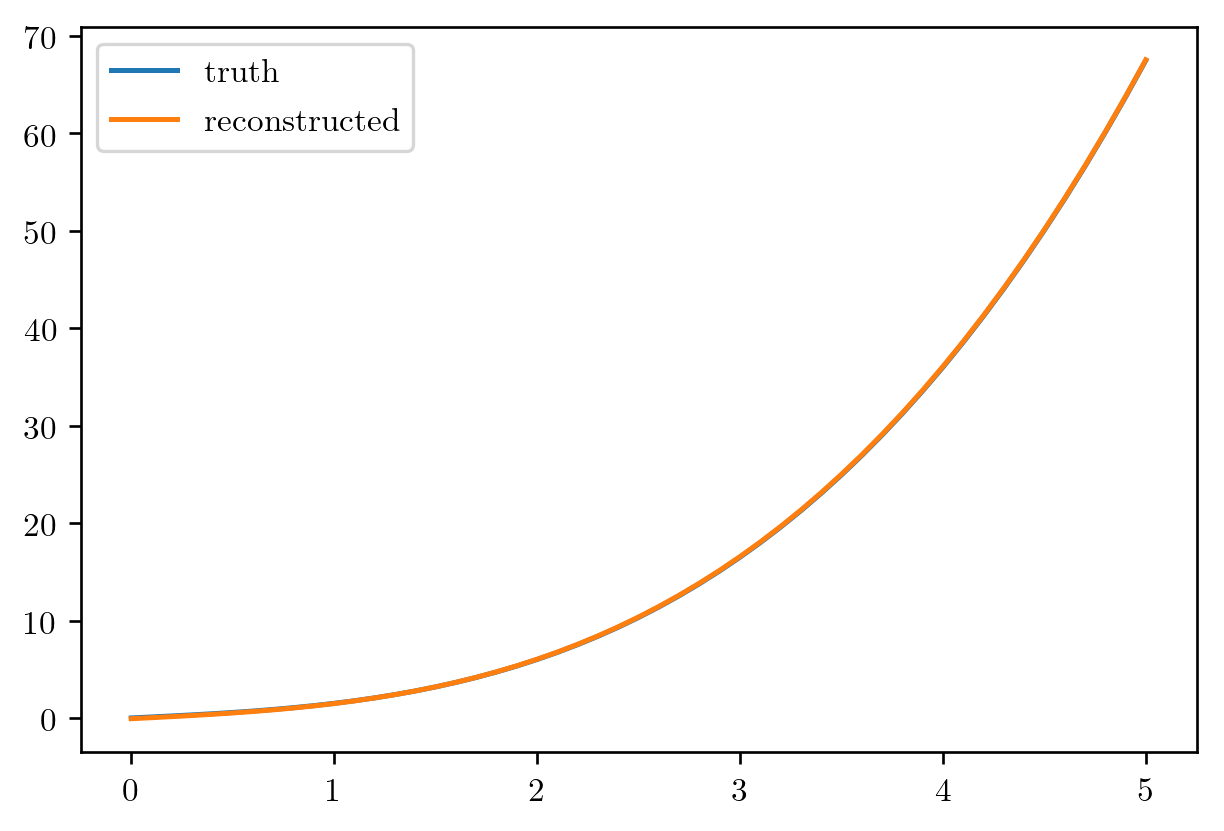

In [7]:
out = {}
for key in sampler.positions.dtype.names:
    out[key] = sampler.positions[key][best_i, -1]
    
print(out)
plt.figure(dpi=120)
plt.plot(model.t, model.ysignal, label='truth')
plt.plot(model.t, model.reconstruct(**out), label='reconstructed')
plt.legend()
plt.show()

## Plot histogram of the transdimensional model indices

Injected signal is: {'a0': 0.0, 'a1': 1.0, 'a2': nan, 'a3': 0.5, 'a4': nan, 'a5': nan, 'k': 2}


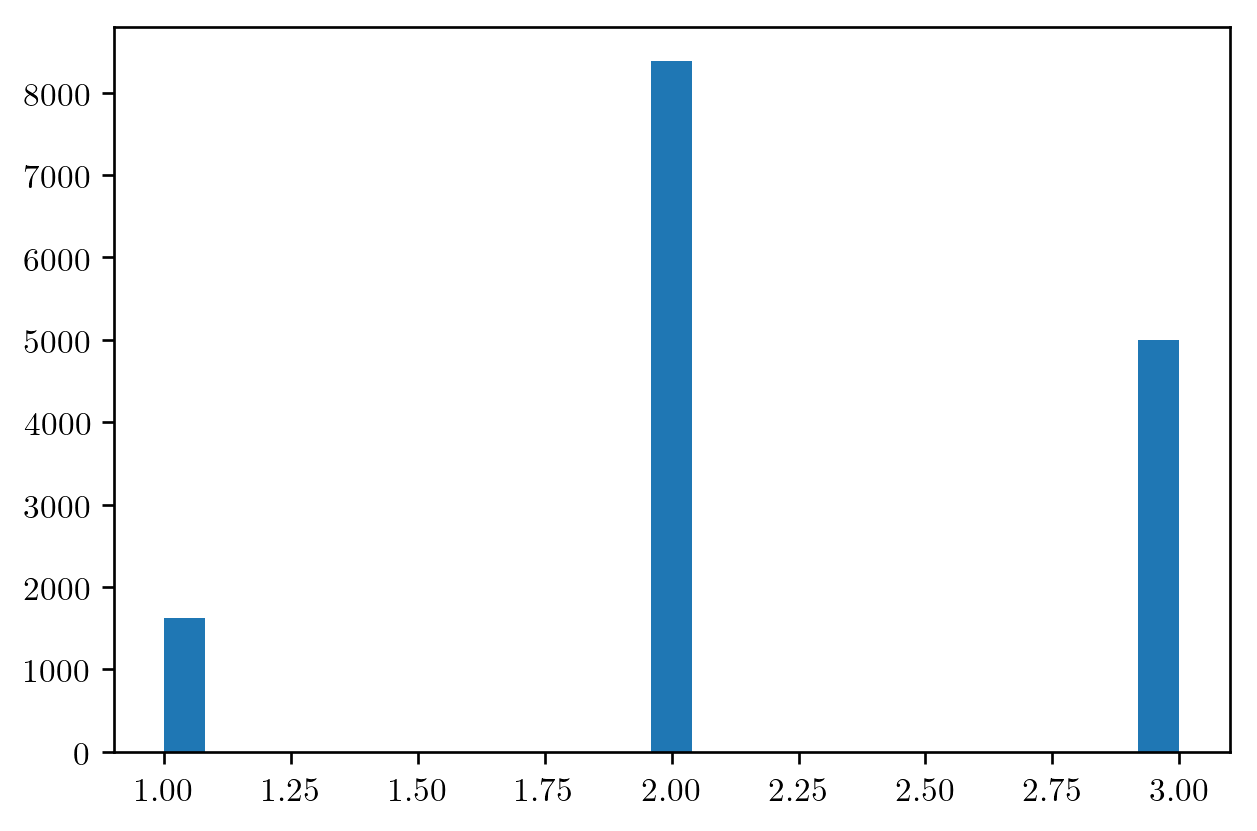

In [8]:
print('Injected signal is:', model.true_signal)

plt.figure(dpi=120)
plt.hist(sampler.positions['k'][:, -5000::4].reshape(-1,), bins='auto')
plt.show()